In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/data_clean.csv', sep=";")
df.drop(['Unnamed: 0'], axis=1, inplace=True) ; df

,Client_ID,Order_ID,Order_Date,Delivery_Date,Status,New_Status,Initial_Order_Sum,Amount,Final_Order_Sum,Amount_Sold,...,Delivery_Cost,Payment_Type,Delivery_Type,Item_Type,Item_Type1,Item_Name,Item_Group,Item_Group1,Region,Is_Moscow
0,55574854-48574951555577,3998972_TR,2017-03-01 11:41:00,2017-03-07,Returned,Returned,12098,1,12247.0,1,...,0,1,Курьерская,КГТ,КГТ,"LEADER KIDS, МУФТА на ручку коляски, (беж),",КРУПНОГАБАРИТНЫЙ ТОВАР,КОЛЯСКИ,Москва,1
1,55575453-56535648535679,3999117_TR,2017-03-01 12:22:00,2017-03-15,Delivered,Delivered,4819,1,3759.0,1,...,0,0,Магазины,ОДЕЖДА,МГТ,"GAMEX, БОДИ кор. рук. Roza, (бел/сер), р. 86, ...","ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),Челябинск,0
2,55574950-57515657535772,3999122_TR,2017-03-01 12:31:00,2017-03-17,Delivered,Delivered,3325,1,3325.0,1,...,0,0,Магазины,ИГРУШКИ,МГТ,"ИГРУША, ХОЛОДИЛЬНИК (на бат), (29,5*19*45,5 см)",ИГРУШКИ,ИГРУШКИ ДЛЯ ДЕВОЧЕК,Нижневартовск,0
3,55574851-55545249535475,3999363_TR,2017-03-01 03:06:00,2017-03-02,Delivered,In Progress,4998,1,4998.0,0,...,0,1,Курьерская,ОДЕЖДА,МГТ,"MAMATTI, ПОЛЗУНКИ Elephant, р. 68, Польша","ТЕКСТИЛЬ, ТРИКОТАЖ",ОДЕЖДА ДЛЯ НОВОРОЖДЕННЫХ (0-2 лет),Москва,1
4,55574854-56495552515179,3999411_TR,2017-03-01 11:38:00,2017-03-14,Delivered,Delivered,528,1,528.0,1,...,0,0,Магазины,ИГРУШКИ,МГТ,"S+S TOYS, ИГРУШКА ПВХ в наборе, (2 шт)",ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,Ижевск,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616848,55574952-51535652495475,4411156_TR,2017-04-17 09:54:00,2017-05-24,In Progress,In Progress,3240,1,3240.0,1,...,0,0,Магазины,КГТ,КГТ,"BABYHIT, КОЛЯСКА (син/черн)",КРУПНОГАБАРИТНЫЙ ТОВАР,КОЛЯСКИ,Чита,0
616849,55575054-53545152544971,4411268_TR,2017-04-17 10:10:00,2017-04-19,Delivered,Delivered,1377,1,1377.0,1,...,49,0,Магазины,ИГРУШКИ,МГТ,"TOMY LAMAZE, КНИЖКА- шуршалка Пират Пит",ИГРУШКИ,ИГРУШКИ ДЛЯ РАЗВИТИЯ МАЛЫШЕЙ,Москва,1
616850,55575448-49564957485078,4411571_TR,2017-04-17 11:03:00,2017-04-27,Delivered,Delivered,1098,1,2086.0,1,...,0,0,Магазины,ППКП,МГТ,"CS MEDICA, НАСАДКА для зубной щетки SonicPulsa...",КОСМЕТИКА/ГИГИЕНА,ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРОЖДЕННЫМИ,Нижний Новгород,0
616851,55575448-49564957485078,4411571_TR,2017-04-17 11:03:00,2017-04-27,Delivered,Delivered,1098,1,2086.0,1,...,0,0,Магазины,ППКП,МГТ,"CS MEDICA, ЩЕТКА зубная эл. SonicPulsar CS-562...",КОСМЕТИКА/ГИГИЕНА,ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРОЖДЕННЫМИ,Нижний Новгород,0


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [5]:
delivered_mask = pd.Series([True if i == 'Delivered' or i == 'In Progress' else False for i in df["New_Status"]])

df["Delivered_Value"] = np.where(delivered_mask, df["Final_Order_Sum"], 0.0)
df["Cancelled_or_Returned"] = df["New_Status"].isin(["Cancelled", "Returned"]).astype(int)

In [6]:
client_base = (
    df.groupby("Client_ID").agg(
        total_orders           = ("Order_ID", "nunique"),
        delivered_orders       = ("Delivered_Value", lambda x: (x > 0).sum()),
        cancelled_or_returned  = ("Cancelled_or_Returned", "sum"),
        avg_bill_delivered     = ("Delivered_Value", lambda x: x[x > 0].mean()),
        avg_items_per_order    = ("Amount", "mean"),
        total_items            = ("Amount", "sum")))

client_base["prop_cancelled"] = (client_base["cancelled_or_returned"] / client_base["total_orders"])

client_base.head()

,total_orders,delivered_orders,cancelled_or_returned,avg_bill_delivered,avg_items_per_order,total_items,prop_cancelled
Client_ID,,,,,,,
0,2269,2185,3741,3599.851854,1.240297,7350,1.648744
32555749-545749525150 .,1,5,0,1088.000000,1.000000,5,0.000000
55494851-56495152535476,1,1,0,1630.000000,1.000000,1,0.000000
55495051-52535455565770,18,0,18,NaN,1.000000,18,1.000000
55505353-48575248535072,1,1,0,7966.000000,1.000000,1,0.000000


In [7]:
def outlier_filter(df, cols, k=1.0):
    P1 = df[cols].quantile(0.10)
    P2 = df[cols].quantile(0.90)
    IPR = P2 - P1                       # inter-percentile range

    lower = P1 - k * IPR
    upper = P2 + k * IPR

    keep_mask = ~((df[cols] < lower) | (df[cols] > upper)).any(axis=1)
    return keep_mask


metrics_for_outliers = [
    "avg_bill_delivered",     # unusually high average receipt
    "avg_items_per_order",    # huge baskets
    "total_orders",           # heavy buyers
]
mask_keep = outlier_filter(client_base, metrics_for_outliers, k=1) #the bigger the k, the less clients are dropped
print(f"Removed {(~mask_keep).sum():,} extreme-behaviour clients "
      f"({(~mask_keep).mean():.2%} of all)")

client_base = client_base[mask_keep] ; client_base

Removed 9,339 extreme-behaviour clients (8.16% of all)


,total_orders,delivered_orders,cancelled_or_returned,avg_bill_delivered,avg_items_per_order,total_items,prop_cancelled
Client_ID,,,,,,,
32555749-545749525150 .,1,5,0,1088.0,1.00,5,0.0
55494851-56495152535476,1,1,0,1630.0,1.00,1,0.0
55505353-48575248535072,1,1,0,7966.0,1.00,1,0.0
55515651-54485252545773,1,0,1,NaN,1.00,1,1.0
55525353-53535353565678,1,0,1,NaN,1.00,1,1.0
...,...,...,...,...,...,...,...
57495456-48525056575193,1,3,0,3178.0,1.00,3,0.0
57505449-54565157515496,1,0,2,NaN,1.00,2,2.0
57545653-57554953575092,1,0,25,NaN,1.04,26,25.0


In [8]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
item_grp_ohe = ohe.fit_transform(df[["Item_Group"]])
item_grp_df = (pd.DataFrame.sparse.from_spmatrix(item_grp_ohe, index=df["Client_ID"], columns=ohe.get_feature_names_out()).groupby(level=0).sum().clip(upper=1))

features = client_base.join(item_grp_df, how="left").fillna(0)
features.drop(index=features.index[0], axis=0, inplace=True)
features.head()

,total_orders,delivered_orders,cancelled_or_returned,avg_bill_delivered,avg_items_per_order,total_items,prop_cancelled,Item_Group_ДЕТСКОЕ ПИТАНИЕ,Item_Group_ЖЕНСКИЕ ШТУЧКИ,Item_Group_ИГРУШКИ,"Item_Group_КАНЦТОВАРЫ, КНИГИ, ДИСКИ",Item_Group_КОСМЕТИКА/ГИГИЕНА,Item_Group_КРУПНОГАБАРИТНЫЙ ТОВАР,Item_Group_ОБУВЬ,Item_Group_ПОДГУЗНИКИ,Item_Group_СОПУТСТВУЮЩИЕ ТОВАРЫ,"Item_Group_ТЕКСТИЛЬ, ТРИКОТАЖ",Item_Group_ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,Item_Group_ТОВАРЫ ДЛЯ ЖИВОТНЫХ,Item_Group_ТОВАРЫ ДЛЯ КОРМЛЕНИЯ
Client_ID,,,,,,,,,,,,,,,,,,,,
55494851-56495152535476,1,1,0,1630.0,1.0,1,0.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0
55505353-48575248535072,1,1,0,7966.0,1.0,1,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
55515651-54485252545773,1,0,1,0.0,1.0,1,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0
55525353-53535353565678,1,0,1,0.0,1.0,1,1.0,0,0,1.0,0,0,0,0,0,0,0,0,0,0
55525453-54485455535276,1,0,1,0.0,1.0,1,1.0,0,0,0,0,0,1.0,0,0,0,0,0,0,0


In [9]:
numeric_cols = client_base.columns.tolist()
binary_item_cols = item_grp_df.columns.tolist()

preproc = ColumnTransformer(transformers=[("num", StandardScaler(), numeric_cols), ("bin", "passthrough", binary_item_cols)])
X = preproc.fit_transform(features)

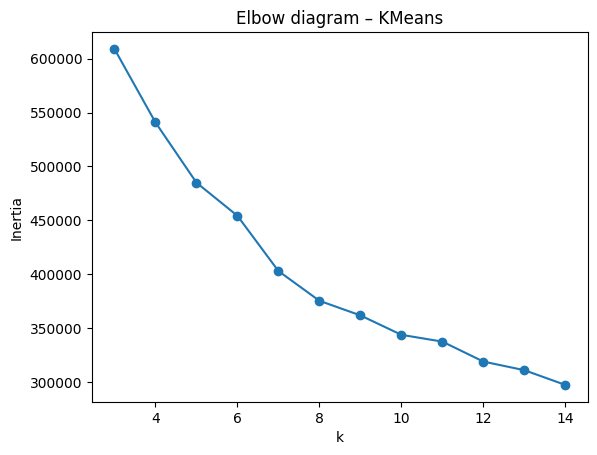

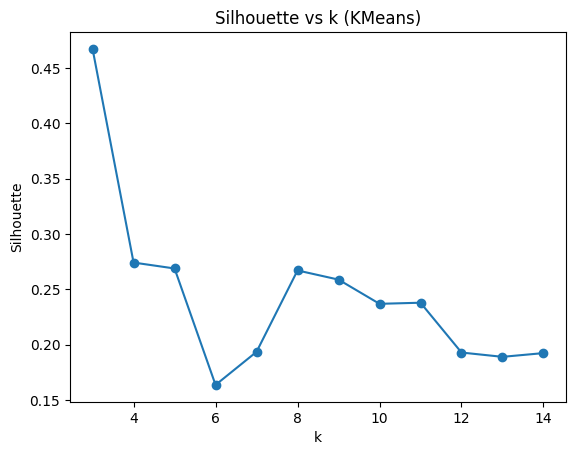

In [13]:
# K-Means
k_range = range(3, 15)
inertias, sils = [], []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto").fit(X)
    labels = km.labels_
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

plt.figure()
plt.plot(k_range, inertias, marker="o")
plt.title("Elbow diagram – KMeans")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()

plt.figure()
plt.plot(k_range, sils, marker="o")
plt.title("Silhouette vs k (KMeans)")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

In [ ]:
best_k = int(pd.Series(sils, index=k_range).idxmin())
# best_k = 6
print(f"Selected k for K-Means: {best_k}")

kmeans_final = KMeans(n_clusters=best_k, n_init="auto", random_state=42).fit(X)
features["cluster_km"] = kmeans_final.labels_

Selected k for K-Means: 6


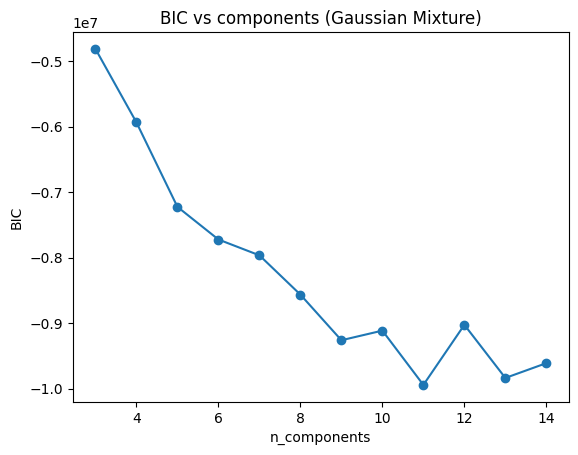

Selected 11 components for Gaussian Mixture


In [16]:
bic, gm_models = [], []
for k in k_range:
    gm = GaussianMixture(n_components=k, covariance_type="full", random_state=42).fit(X.toarray() if hasattr(X, "toarray") else X)
    bic.append(gm.bic(X))
    gm_models.append(gm)

plt.figure()
plt.plot(k_range, bic, marker="o")
plt.title("BIC vs components (Gaussian Mixture)")
plt.xlabel("n_components"); plt.ylabel("BIC")
plt.show()

best_idx = int(np.argmin(bic))
gm_best = gm_models[best_idx]
features["cluster_gm"] = gm_best.predict(X)
print(f"Selected {k_range[best_idx]} components for Gaussian Mixture")

In [ ]:
eps_vals = np.linspace(1.4, 2.0, 3)
min_samp_vals = [5, 10]
results = []

X_dense = (X.toarray() if hasattr(X, "toarray") else X).astype(np.float32)

for eps in eps_vals:
    for m in min_samp_vals:
        db = DBSCAN(eps=eps, min_samples=m).fit(X_dense)
        labels = db.labels_
        if (labels != -1).sum() < 2:
            continue
        sil = silhouette_score(X_dense, labels, sample_size=10000, random_state=42)
        dbs = davies_bouldin_score(X_dense, labels)
        results.append({"eps": eps, "min_samples": m, "silhouette": sil, "db_index": dbs})

dbscan_results = pd.DataFrame(results).sort_values("silhouette", ascending=False)
display(dbscan_results.head())

# Fit best DBSCAN
best = dbscan_results.iloc[0]
dbscan_final = DBSCAN(eps=best.eps, min_samples=int(best.min_samples)).fit(X)
features["cluster_db"] = dbscan_final.labels_
print(f"DBSCAN chosen: eps={best.eps}, min_samples={int(best.min_samples)}")

In [18]:
def scores(X, labels):
    return {
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
        "silhouette": silhouette_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels)}

summary = pd.DataFrame({
    "KMeans": scores(X, features["cluster_km"]),
    "GaussMix": scores(X, features["cluster_gm"]),
    # "DBSCAN": scores(X_dense, features["cluster_db"])
    }).T

display(summary)

,n_clusters,silhouette,davies_bouldin
KMeans,6.0,0.163524,1.494176
GaussMix,11.0,0.040234,3.019058


In [19]:
import matplotlib as mpl
blue_cmap = mpl.colormaps.get_cmap("Blues")
teal_cmap = mpl.colormaps.get_cmap("PuBuGn")

def style_kpi(df):
    pct_cols = ["Revenue %", "Orders %", "Clients %"]
    return (
        df.style
          .format({c:"{:.2f}%" for c in pct_cols} |
                  {"Avg_ticket":"{:,.0f} ₽", "Avg_items":"{:,.2f}"})
          .background_gradient(cmap=blue_cmap, subset=pct_cols)
          .background_gradient(cmap=teal_cmap.reversed(), subset=["Avg_ticket", "Avg_items"])
          .highlight_max(color="#c6dbef", axis=0, subset=pct_cols))

def style_mix(df):
    return (
        df.style
          .format("{:.2f}%")
          .background_gradient(cmap=blue_cmap)
          .highlight_max(color="#c6dbef", axis=1)
          .highlight_max(color="#c6dbef", axis=0, subset=["Clients %"]))

In [20]:
df_prof = df.merge(features["cluster_km"], left_on="Client_ID", right_index=True)
tot_revenue = df_prof["Final_Order_Sum"].sum()
tot_orders  = df_prof["Order_ID"].nunique()
tot_clients = features.shape[0]          

cluster_kpi = (
    df_prof.groupby("cluster_km")
            .agg(
                Revenue_sum  = ("Final_Order_Sum", "sum"),
                Orders_cnt   = ("Order_ID", "nunique"),
                Avg_ticket   = ("Final_Order_Sum", "mean"),
                Avg_items    = ("Amount", "mean")))

cluster_kpi["Revenue %"] = 100 * cluster_kpi["Revenue_sum"] / tot_revenue
cluster_kpi["Orders %"]  = 100 * cluster_kpi["Orders_cnt"]  / tot_orders
cluster_kpi["Clients %"] = (100 * features["cluster_km"].value_counts(normalize=True).sort_index())

cluster_kpi = cluster_kpi[["Revenue %", "Orders %", "Clients %", "Avg_ticket", "Avg_items"]].round(2)
display(style_kpi(cluster_kpi))

,Revenue %,Orders %,Clients %,Avg_ticket,Avg_items
cluster_km,,,,,
0,10.90%,18.15%,21.75%,"3,295 ₽",0.91
1,21.38%,3.86%,2.04%,"4,763 ₽",1.67
2,18.90%,24.17%,11.33%,"2,699 ₽",1.21
3,15.13%,8.63%,10.27%,"6,873 ₽",1.13
4,16.05%,42.49%,52.63%,"2,083 ₽",1.16
5,17.65%,2.70%,1.98%,"6,264 ₽",1.19


In [21]:
rev_mix = (df_prof.groupby(["cluster_km", "Item_Group"])["Final_Order_Sum"].sum().unstack(fill_value=0))

rev_mix_pct = (rev_mix.div(rev_mix.sum(axis=1), axis=0) * 100).round(2)
rev_mix_pct["Clients %"] = cluster_kpi["Clients %"]

display(style_mix(rev_mix_pct))

Item_Group,ДЕТСКОЕ ПИТАНИЕ,ЖЕНСКИЕ ШТУЧКИ,ИГРУШКИ,"КАНЦТОВАРЫ, КНИГИ, ДИСКИ",КОСМЕТИКА/ГИГИЕНА,КРУПНОГАБАРИТНЫЙ ТОВАР,ОБУВЬ,ПОДГУЗНИКИ,СОПУТСТВУЮЩИЕ ТОВАРЫ,"ТЕКСТИЛЬ, ТРИКОТАЖ",ТЕХНИКА И ТОВАРЫ ДЛЯ ДОМА,ТОВАРЫ ДЛЯ ЖИВОТНЫХ,ТОВАРЫ ДЛЯ КОРМЛЕНИЯ,Clients %
cluster_km,,,,,,,,,,,,,,
0,1.39%,0.04%,13.88%,1.84%,1.86%,23.59%,18.93%,3.48%,0.11%,32.27%,0.01%,0.20%,2.41%,21.75%
1,47.76%,0.22%,9.08%,4.27%,12.97%,1.40%,1.08%,6.42%,0.15%,10.19%,0.00%,1.28%,5.19%,2.04%
2,14.53%,0.13%,16.33%,3.70%,10.75%,6.75%,5.25%,13.84%,0.18%,21.04%,0.01%,0.88%,6.61%,11.33%
3,6.43%,0.12%,17.68%,2.57%,8.84%,25.26%,3.81%,7.49%,0.23%,19.89%,0.00%,0.54%,7.14%,10.27%
4,9.17%,0.09%,27.80%,3.89%,7.91%,8.11%,4.27%,15.71%,0.22%,15.83%,0.01%,1.20%,5.78%,52.63%
5,10.36%,0.15%,15.40%,5.05%,7.52%,1.86%,12.86%,3.13%,0.27%,39.17%,0.01%,0.41%,3.83%,1.98%


In [29]:
import plotly.express as px
fig = px.imshow(
        rev_mix_pct.drop(columns="Clients %"),
        labels=dict(x="Item group", y="Cluster", color="% of revenue"),
        aspect="auto",
        color_continuous_scale="Blues",
        text_auto='.1f')
        

fig.update_layout(title="Item-group revenue mix by K-means cluster")
fig.show()

In [30]:
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [34]:
def build_basket(df_lines, id_col="Client_ID", item_col="Item_Group1"):
    basket = (df_lines.groupby([id_col, item_col])["Order_ID"].size().unstack(fill_value=0))
    return (basket > 0)


def mine_rules(basket, algo="apriori", min_support=0.03, min_conf=0.2):
    if algo == "apriori":
        freq = apriori(basket, min_support=min_support, use_colnames=True)
    elif algo == "fpgrowth":
        freq = fpgrowth(basket, min_support=min_support, use_colnames=True)
    else:
        raise ValueError("algo must be 'apriori' or 'fpgrowth'")

    rules = association_rules(freq, metric="confidence", min_threshold=min_conf)
    return rules.sort_values("lift", ascending=False).reset_index(drop=True)

In [36]:
slide_data = {}

for cl in sorted(features["cluster_km"].unique()):
    df_cl = df_prof[df_prof["cluster_km"] == cl]
    basket_cl = build_basket(df_cl, item_col="Item_Group1")

    rules_ap = mine_rules(basket_cl, algo="apriori")
    rules_fp = mine_rules(basket_cl, algo="fpgrowth")

    top_rules = (
        pd.concat([rules_ap.head(3), rules_fp.head(3)])
          .drop_duplicates(subset=["antecedents", "consequents"])
          .reset_index(drop=True)
    )

    if top_rules.empty:                   # ← guard
        print(f"Cluster {cl}: no rules found – skipped")
        continue

    # top_rules = (pd.concat([rules_ap.head(3), rules_fp.head(3)]).drop_duplicates(subset=["antecedents", "consequents"]).reset_index(drop=True))

    r0 = top_rules.iloc[0]
    ante = next(iter(r0["antecedents"]))
    conse = next(iter(r0["consequents"]))

    clients_ante  = basket_cl[ante].sum()
    clients_both  = basket_cl[(basket_cl[ante] == 1) &(basket_cl[conse] == 1)].shape[0]
    avg_margin_con = df_cl.loc[df_cl["Item_Group1"] == conse, "Total_Profit_Margin"].mean()
    targetable    = int(clients_ante - clients_both)

    bullets = [
        f"Made purchases in “{ante}” — **{clients_ante}** clients",
        f"Of them, **{clients_both}** also bought “{conse}”",
        f"Average margin in “{conse}” is **{avg_margin_con:,.1f} ₽**",
        f"**{targetable}** clients can be targeted with “{conse}” offers",
    ]

    slide_data[cl] = dict(rules=top_rules, bullets=bullets)


for cl, d in slide_data.items():
    display(pd.DataFrame({f"Cluster {cl}": []}))
    display(d["rules"][["antecedents", "consequents",
                        "support", "confidence", "lift"]])
    for line in d["bullets"]:
        print(" •", line)
    print("-" * 65)


Cluster 0: no rules found – skipped
Cluster 4: no rules found – skipped


,Cluster 1


,antecedents,consequents,support,confidence,lift
0,"(СРЕДСТВА ГИГИЕНЫ, БУТЫЛОЧКИ)","(АКСЕССУАРЫ, СОСКИ/ПУСТЫШКИ)",0.031672,0.468966,5.327349
1,"(АКСЕССУАРЫ, СОСКИ/ПУСТЫШКИ)","(СРЕДСТВА ГИГИЕНЫ, БУТЫЛОЧКИ)",0.031672,0.359788,5.327349
2,"(ПОЛИГРАФИЧЕСКАЯ ПРОДУКЦИЯ, КАНЦТОВАРЫ)",(ТВОРЧЕСТВО),0.032604,0.469799,5.226206


 • Made purchases in “СРЕДСТВА ГИГИЕНЫ” — **904** clients
 • Of them, **348** also bought “АКСЕССУАРЫ”
 • Average margin in “АКСЕССУАРЫ” is **53.9 ₽**
 • **556** clients can be targeted with “АКСЕССУАРЫ” offers
-----------------------------------------------------------------


,Cluster 2


,antecedents,consequents,support,confidence,lift
0,(БУТЫЛОЧКИ),(СОСКИ/ПУСТЫШКИ),0.030728,0.446341,4.806847
1,(СОСКИ/ПУСТЫШКИ),(БУТЫЛОЧКИ),0.030728,0.330922,4.806847
2,(КАШИ),(ПЮРЕ),0.059189,0.470942,3.668665
3,(ПЮРЕ),(КАШИ),0.059189,0.461086,3.668665


 • Made purchases in “БУТЫЛОЧКИ” — **820** clients
 • Of them, **366** also bought “СОСКИ/ПУСТЫШКИ”
 • Average margin in “СОСКИ/ПУСТЫШКИ” is **43.5 ₽**
 • **454** clients can be targeted with “СОСКИ/ПУСТЫШКИ” offers
-----------------------------------------------------------------


,Cluster 3


,antecedents,consequents,support,confidence,lift
0,(СРЕДСТВА ГИГИЕНЫ),(ПОДГУЗНИКИ),0.036045,0.771825,5.605343
1,(ПОДГУЗНИКИ),(СРЕДСТВА ГИГИЕНЫ),0.036045,0.261777,5.605343


 • Made purchases in “СРЕДСТВА ГИГИЕНЫ” — **504** clients
 • Of them, **389** also bought “ПОДГУЗНИКИ”
 • Average margin in “ПОДГУЗНИКИ” is **53.0 ₽**
 • **115** clients can be targeted with “ПОДГУЗНИКИ” offers
-----------------------------------------------------------------


,Cluster 5


,antecedents,consequents,support,confidence,lift
0,"(СРЕДСТВА ГИГИЕНЫ, ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРО...","(АКСЕССУАРЫ, ДЕТСКАЯ КОСМЕТИКА)",0.034599,0.517986,5.955404
1,"(АКСЕССУАРЫ, ДЕТСКАЯ КОСМЕТИКА)","(СРЕДСТВА ГИГИЕНЫ, ПРЕДМЕТЫ ПО УХОДУ ЗА НОВОРО...",0.034599,0.397790,5.955404
2,"(СРЕДСТВА ГИГИЕНЫ, ТОВАРЫ ДЛЯ МАМ)",(ПЕЛЕНКИ ОДНОРАЗОВЫЕ),0.031235,0.511811,5.917104


 • Made purchases in “СРЕДСТВА ГИГИЕНЫ” — **423** clients
 • Of them, **175** also bought “АКСЕССУАРЫ”
 • Average margin in “АКСЕССУАРЫ” is **46.1 ₽**
 • **248** clients can be targeted with “АКСЕССУАРЫ” offers
-----------------------------------------------------------------
